**Sentimentos Vader e SenticNet x Casos Covid**

Importações e configurações do banco de dados

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

from statistics import mean

In [3]:
from pymongo import MongoClient
client = MongoClient('localhost', 27017)
db = client.SpedDB
collection = db.tweets_brasil

**Ranking de Sentimentos utilizando Vader**

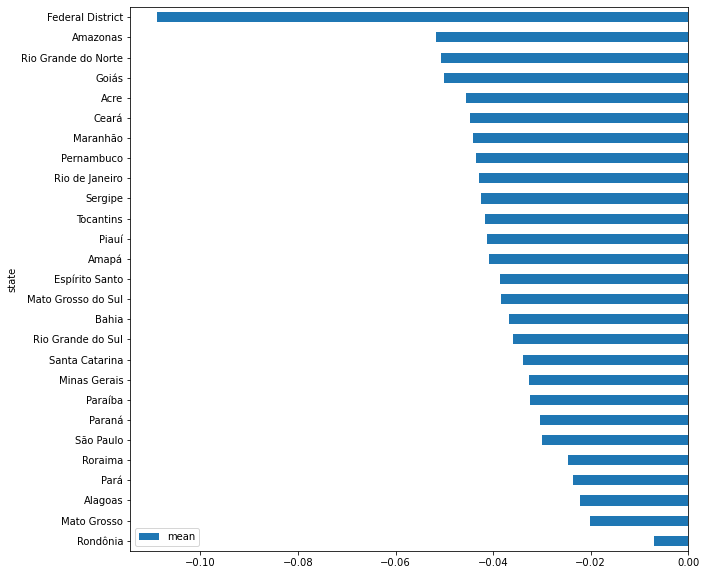

In [56]:
# Ranking de estados por média de sentimentos (pior para o melhor)
df2_by_score = df2.groupby('state')['score'].agg(['mean'])
df2_by_score.sort_values(by='mean',ascending=False).plot(kind='barh', figsize=(10, 10))

In [57]:
# Selecionando somente as capitais
df_capitals = df2.query("city in ['Rio Branco', 'Maceió', 'Macapá', 'Manaus', 'Salvador', 'Fortaleza', 'Brasília', 'Vitória', 'Goiânia', 'São Luís', 'Cuiabá', 'Campo Grande', 'Belo Horizonte', 'Belém', 'João Pessoa', 'Curitiba', 'Recife', 'Teresina', 'Rio de Janeiro', 'Natal', 'Porto Alegre', 'Porto Velho', 'Boa Vista', 'Florianópolis', 'São Paulo', 'Aracaju', 'Palmas']")
df_capitals.shape[0]

444839

In [58]:
# Ranking das 5 estados mais "tristes"
df_capitals_by_score = df_capitals.groupby('city')['score'].agg(['mean'])
df_capitals_by_score = df_capitals_by_score.sort_values(by='mean',ascending=True)
df_capitals_by_score_worst = df_capitals_by_score[:5]
df_capitals_by_score_worst

,mean
city,
Cuiabá,-0.056800
Palmas,-0.056439
Recife,-0.054813
Goiânia,-0.053894
Manaus,-0.053719


In [59]:
# Ranking das 5 estados mais "felizes"
df_capitals_by_score = df_capitals.groupby('city')['score'].agg(['mean'])
df_capitals_by_score = df_capitals_by_score.sort_values(by='mean',ascending=False)
df_capitals_by_score_best = df_capitals_by_score[:5]
df_capitals_by_score_best

,mean
city,
Porto Velho,-0.008655
Maceió,-0.012655
Belém,-0.020804
Boa Vista,-0.025339
Vitória,-0.029105


**Ranking de Sentimentos utilizando SenticNet**

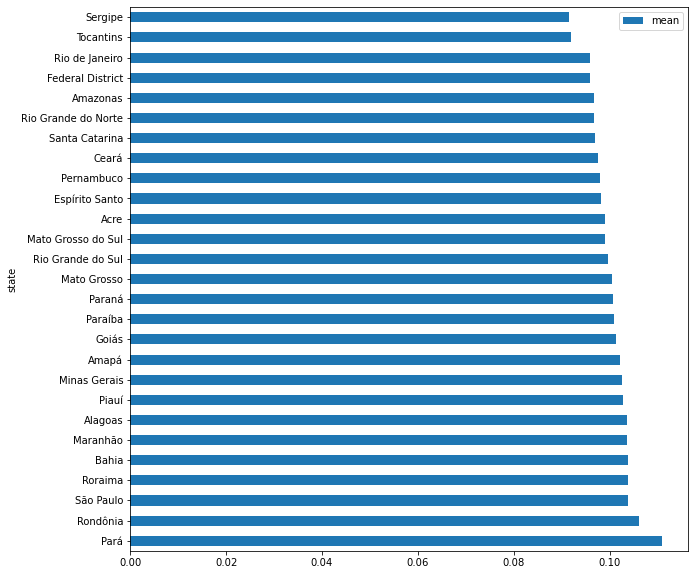

In [60]:
# Ranking de estados por média de sentimentos (pior para o melhor)
df2_by_score = df2.groupby('state')['polarity'].agg(['mean'])
df2_by_score.sort_values(by='mean',ascending=False).plot(kind='barh', figsize=(10, 10))

In [61]:
# Selecionando somente as capitais
df_capitals = df2.query("city in ['Rio Branco', 'Maceió', 'Macapá', 'Manaus', 'Salvador', 'Fortaleza', 'Brasília', 'Vitória', 'Goiânia', 'São Luís', 'Cuiabá', 'Campo Grande', 'Belo Horizonte', 'Belém', 'João Pessoa', 'Curitiba', 'Recife', 'Teresina', 'Rio de Janeiro', 'Natal', 'Porto Alegre', 'Porto Velho', 'Boa Vista', 'Florianópolis', 'São Paulo', 'Aracaju', 'Palmas']")
df_capitals.shape[0]

444839

In [62]:
# Ranking das 5 estados mais "tristes"
df_capitals_by_polarity = df_capitals.groupby('city')['polarity'].agg(['mean'])
df_capitals_by_polarity = df_capitals_by_polarity.sort_values(by='mean',ascending=True)
df_capitals_by_polarity_worst = df_capitals_by_polarity[:5]
df_capitals_by_polarity_worst

,mean
city,
Aracaju,0.089123
Rio de Janeiro,0.094458
Fortaleza,0.095666
Manaus,0.096295
Recife,0.097329


In [63]:
# Ranking das 5 estados mais "felizes"
df_capitals_by_polarity = df_capitals.groupby('city')['polarity'].agg(['mean'])
df_capitals_by_polarity = df_capitals_by_polarity.sort_values(by='mean',ascending=False)
df_capitals_by_polarity_best = df_capitals_by_polarity[:5]
df_capitals_by_polarity_best

,mean
city,
Belém,0.120412
Teresina,0.106837
São Paulo,0.105350
Boa Vista,0.104934
Porto Velho,0.104427


Selecionando dados de registros com geo_source mais confiáveis (place e user_location)

In [18]:
df2 = pd.DataFrame.from_records(collection.find({'score': {'$ne':None}, 'polarity':{'$ne':None}, '$or':[{'geo_source':'place'}, {'geo_source':'user_location'}]}, {'state':1,'city':1,'lang':1,'geo_source':1,'score':1,'created_at':1,'text':1,'polarity':1,'_id': 0}))

In [6]:
df2.shape[0]

741638

Funções auxiliares para dataframes

In [19]:
# Função para montar um df de Quantificadores por data a partir do df de Tweets
def building_dates_df(df, column):

    date_set = set()  
    
    for item in df.created_at:
        date = datetime.datetime(item.year, item.month, item.day)
        date_set.add(date)
    
    # Listas utilizadas para montagem do df
    date_list = list(date_set)
    date_list.sort()
    score_mean_list = []
        
    # Populando quantificadores para cada dia
    for index in date_list:
        # Média de scores do período
        score_mean = mean(df[column].loc[(df['created_at'].dt.year == index.year) & (df['created_at'].dt.month == index.month) & (df['created_at'].dt.day == index.day)])
        score_mean_list.append(score_mean)
    
    # Dicionário utilizado como parâmetro para a montagem
    column_mean = column + '_mean'
    data={'created_at': pd.Series(date_list),column_mean:pd.Series(score_mean_list)}
    
    # Criando df
    df = pd.DataFrame(data)
    
    return df 

In [20]:
# Função para retornar todos os casos de uma cidade
def filter_cases_city (df_cases_brasil, city, state_code):
    
    df_cases_city = df_cases_brasil.loc[(df_cases_brasil['city'] == city) & (df_cases_brasil['state'] == state_code) & (df_cases_brasil['date'] < '2020-05-02')]
    df_cases_city = df_cases_city.reset_index(drop=True)
    
    return df_cases_city

In [21]:
# Função para retornar os tweets a partir da data do primeiro caso de covid na cidade
def filter_tweets_city(df_cases_city, df_tweets, city, state):
    
    # Retornando a data do primeiro caso de Covid
    date_str = df_cases_city.loc[0, 'date']
    datetime_str = date_str + ' 00:00:00'
    
    # Selecionando tweets a partir da data do primeiro caso
    query_str = "city == '"+city+"' and state == '"+state+"' and created_at >= '"+datetime_str+"'";  
    
    return df_tweets.query(query_str)

In [22]:
# Realizando o merge do dataframe de scores x dataframe de casos
def merge_dfs(df_scores_city, df_cases_city):

    # Padronizando as colunas de datas
    df_scores_city = df_scores_city.rename(columns={'created_at':'date'})

    # Convertendo as colunas de datas para o mesmo tipo de objeto
    df_scores_city = df_scores_city.astype({'date': str})
    df_cases_city = df_cases_city.astype({'date': str})

    # Realizando merges para recuperar período de datas em comum
    return pd.merge(df_scores_city, df_cases_city, on='date', how='inner')

In [23]:
# Função para derivar novos atributos
def create_attributes(df_merged):
    
    # Somando colunas new_confirmed + new_deaths (notícias ruins do dia)
    df_merged['bad_news'] = df_merged['new_confirmed'] + df_merged['new_deaths']

    # Somando colunas last_available_confirmed + last_available_deaths (notícias ruins totais)
    df_merged['last_bad_news'] = df_merged['last_available_confirmed'] + df_merged['last_available_deaths']

    # Calculando percentual de crescimento de score de sentimento em relação ao dia anterior
    # df_merged = calculate_percent(df_merged, 'score_mean', 'score_mean_pct')

    # Calculando percentual de crescimento diário de novos casos em relação ao dia anterior
    df_merged = calculate_percent(df_merged, 'new_confirmed', 'new_confirmed_pct')

    # Calculando percentual de crescimento diário de novas mortes em relação ao dia anterior
    df_merged = calculate_percent(df_merged, 'new_deaths', 'new_deaths_pct')

    # Calculando percentual de crescimento diário de novos casos em relação ao total
    df_merged = calculate_percent(df_merged, 'last_available_confirmed', 'last_available_confirmed_pct')

    # Calculando percentual de crescimento diário de novas mortes em relação ao total
    df_merged = calculate_percent(df_merged, 'last_available_deaths', 'last_available_deaths_pct')

    # Calculando percentual de crescimento diário de novas mortes por 100k habitantes em relação ao total
    df_merged = calculate_percent(df_merged, 'last_available_confirmed_per_100k_inhabitants', 'last_available_confirmed_per_100k_inhabitants_pct')

    # Calculando percentual de crescimento diário da taxa de mortalidade em relação ao total
    df_merged = calculate_percent(df_merged, 'last_available_death_rate', 'last_available_death_rate_pct')

    # Calculando percentual de crescimento de notícias ruins em relação ao dia anterior
    df_merged = calculate_percent(df_merged, 'bad_news', 'bad_news_pct')

    # Calculando percentual de crescimento de notícias ruins em relação ao total
    df_merged = calculate_percent(df_merged, 'last_bad_news', 'last_bad_news_pct')
    
    return df_merged;

Funções auxiliares para gráficos

In [24]:
# Função para geração de gráficos
def generate_graphic(df, x, y, label, color, xLabel, yLabel, title):
    
    plt.rcParams['figure.figsize'] = (18,9)
    plt.plot(x,y,color=color, linestyle='solid', linewidth=2,label=label)
    
    plt.xticks(x, rotation=80)
    plt.legend(fontsize=15)
    plt.xlabel(xLabel,fontsize=15)
    plt.ylabel(yLabel,fontsize=15)
    plt.title(title)
    plt.grid(True, linestyle='--')
    plt.show()

In [25]:
# Função para gerar um gráfico X outro
def generate_vs_graphic(date, x, y1, y2, label1, label2, color1, color2, xLabel, title):
    
    plt.rcParams['figure.figsize'] = (18,9)
    plt.plot(x,y1,color=color1, linestyle='solid', linewidth=2,label=label1)
    plt.plot(x,y2,color=color2, linestyle='solid', linewidth=2,label=label2)

    plt.xticks(date, rotation=80)
    plt.legend(fontsize=15)
    plt.xlabel(xLabel,fontsize=15)
    plt.title(title)
    plt.grid(True, linestyle='--')
    plt.show()

In [26]:
# Função para gerar scatter plot
def generate_scatter(x, y, x_name, y_name):
    
    plt.figure(figsize=(8, 4), dpi=80)
    plt.scatter(x, y)
    plt.title(x_name + " X " + y_name)
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    
    return plt

Funções auxiliares para o cálculo de atributos

In [27]:
## Cálculo do percentual de crescimento de um valor no tempo
def calculate_percent(df, column, new_column):  
    
    values_list = []
    
    is_first = True
    last_value = 0
    
    for (i, row) in df.iterrows():
        if (is_first == True):
            is_first = False
            last_value = row[column]
            values_list.append(0)
        else:
            try:
                percent = 100 * (((row[column] - last_value))/last_value)
                percent = round(percent, 2)
                values_list.append(percent)
                last_value = row[column]
            except ZeroDivisionError:
                values_list.append(0)
                last_value = row[column]
            
    df[new_column] = pd.Series(values_list, index = df.index)
    
    return df

Funções auxiliares para correlações

In [28]:
def best_column_corr(corr_matrix):
    return corr_matrix.index[1]

In [29]:
def prepare_data(df_cases, df_tweets, city, state, state_code, column):
    
    # Filtrando registros de casos de Covid
    df_cases_city = filter_cases_city(df_cases, city, state_code)
    #print(df_cases_city.shape[0])

    # Filtrando tweets a partir da data do primeiro caso registrado
    df_tweets_city = filter_tweets_city(df_cases_city, df_tweets, city, state)
    #print(df_tweets_city.shape[0])

    # Montando dataframe com a média de scores de sentimentos por data (existe uma data sem dados)
    df_scores_city = building_dates_df(df_tweets_city, column)
    #print(df_scores_city.shape[0])

    # Realizando o merge dos dataframes de média de scores x dataframe de casos
    df_merged = merge_dfs(df_scores_city, df_cases_city)
    #print(df_merged.shape[0])

    # Criando atributos derivados
    df_merged = create_attributes(df_merged)
    
    return df_merged

**Casos de Covid-19 no Brasil**

Carregando dados do brasil.io

In [4]:
# Carregando arquivo CSV contendo casos de covid 19 do Brasil
file = '/home/mario/Documentos/LCDIA/Analytics/Datasets/caso_full.csv'
df_cases_brasil = pd.read_csv(file, usecols=['city', 'state', 'date', 'new_confirmed', 'new_deaths','last_available_confirmed','last_available_deaths','last_available_confirmed_per_100k_inhabitants','last_available_death_rate'])

In [118]:
df_cases_brasil.head()

,city,date,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_death_rate,last_available_deaths,state,new_confirmed,new_deaths
0,São Paulo,2020-02-25,1,0.00811,0.0,0,SP,1,0
1,NaN,2020-02-25,1,0.00216,0.0,0,SP,1,0
2,São Paulo,2020-02-26,1,0.00811,0.0,0,SP,0,0
3,NaN,2020-02-26,1,0.00216,0.0,0,SP,0,0
4,São Paulo,2020-02-27,1,0.00811,0.0,0,SP,0,0


In [5]:
df_cases_brasil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 886533 entries, 0 to 886532
Data columns (total 9 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   city                                           880670 non-null  object 
 1   date                                           886533 non-null  object 
 2   last_available_confirmed                       886533 non-null  int64  
 3   last_available_confirmed_per_100k_inhabitants  869244 non-null  float64
 4   last_available_death_rate                      886533 non-null  float64
 5   last_available_deaths                          886533 non-null  int64  
 6   state                                          886533 non-null  object 
 7   new_confirmed                                  886533 non-null  int64  
 8   new_deaths                                     886533 non-null  int64  
dtypes: float64(2), int64(4), object(3)
mem

Correlações - Vader

In [30]:
df_scores_brasil = building_dates_df(df2, 'score')
df_merged_brasil = merge_dfs(df_scores_brasil, df_cases_brasil)
df_merged_brasil = create_attributes(df_merged_brasil)

In [31]:
target_column = 'score_mean'
corr_matrix = df_merged_brasil.corr()
corr_matrix[target_column].sort_values(ascending=False).head()

score_mean                                           1.000000
new_deaths_pct                                       0.002919
last_available_death_rate_pct                       -0.000106
last_available_confirmed_per_100k_inhabitants_pct   -0.000822
new_confirmed_pct                                   -0.002348
Name: score_mean, dtype: float64

Correlações - SentiNet

In [32]:
df_polarities_brasil = building_dates_df(df2, 'polarity')
df_merged_brasil = merge_dfs(df_polarities_brasil, df_cases_brasil)
df_merged_brasil = create_attributes(df_merged_brasil)

In [33]:
target_column = 'polarity_mean'
corr_matrix = df_merged_brasil.corr()
corr_matrix[target_column].sort_values(ascending=False).head()

polarity_mean                1.000000
last_available_death_rate    0.021988
new_deaths_pct               0.008926
last_bad_news_pct            0.000144
last_available_deaths        0.000055
Name: polarity_mean, dtype: float64

In [34]:
df_tweets = df2

**5 cidades com piores scores - Vader**

**Cuiabá (MT)**

In [35]:
city = 'Cuiabá'
state_code = 'MT'
state = 'Mato Grosso'
column = 'score'

df_merged = prepare_data(df_cases_brasil, df_tweets, city, state, state_code, column)

target_column = 'score_mean'
corr_matrix = df_merged.corr()
corr_matrix[target_column].sort_values(ascending=False).head()

score_mean                   1.000000
last_available_death_rate    0.198320
last_available_deaths        0.184615
new_confirmed_pct            0.086244
last_bad_news_pct            0.084945
Name: score_mean, dtype: float64

In [36]:
# best_column = best_column_corr(corr_matrix)

# plt = generate_scatter(df_merged[target_column].array, df_merged[best_column].array, target_column, best_column)
# plt.show()

**Palmas (TO)**

In [37]:
df_tweets = df2
city = 'Palmas'
state_code = 'TO'
state = 'Tocantins'
column = 'score'

df_merged = prepare_data(df_cases_brasil, df_tweets, city, state, state_code, column)

target_column = 'score_mean'
corr_matrix = df_merged.corr()
corr_matrix[target_column].sort_values(ascending=False).head()

score_mean                                           1.000000
last_available_confirmed_per_100k_inhabitants_pct    0.040629
last_available_confirmed_pct                         0.040629
last_bad_news_pct                                    0.029899
new_deaths_pct                                      -0.088994
Name: score_mean, dtype: float64

**Recife (PE)**

In [38]:
city = 'Recife'
state_code = 'PE'
state = 'Pernambuco'
column = 'score'

df_merged = prepare_data(df_cases_brasil, df_tweets, city, state, state_code, column)

target_column = 'score_mean'
corr_matrix = df_merged.corr()
corr_matrix[target_column].sort_values(ascending=False).head()

score_mean                       1.000000
last_available_death_rate_pct    0.107334
new_deaths_pct                   0.074044
last_bad_news_pct                0.041424
last_available_confirmed_pct     0.040216
Name: score_mean, dtype: float64

**Goiânia (GO)**

In [39]:
city = 'Goiânia'
state_code = 'GO'
state = 'Goiás'
column = 'score'

df_merged = prepare_data(df_cases_brasil, df_tweets, city, state, state_code, column)

target_column = 'score_mean'
corr_matrix = df_merged.corr()
corr_matrix[target_column].sort_values(ascending=False).head()

score_mean                                           1.000000
last_bad_news_pct                                    0.237754
last_available_confirmed_per_100k_inhabitants_pct    0.236608
last_available_confirmed_pct                         0.236608
new_deaths_pct                                       0.181506
Name: score_mean, dtype: float64

**Manaus (AM)**

In [40]:
city = 'Manaus'
state_code = 'AM'
state = 'Amazonas'
column = 'score'

df_merged = prepare_data(df_cases_brasil, df_tweets, city, state, state_code, column)

target_column = 'score_mean'
corr_matrix = df_merged.corr()
corr_matrix[target_column].sort_values(ascending=False).head()

score_mean                                           1.000000
last_available_confirmed_pct                         0.091354
last_available_confirmed_per_100k_inhabitants_pct    0.091350
last_bad_news_pct                                    0.091304
new_deaths_pct                                       0.041668
Name: score_mean, dtype: float64

**5 cidades com melhores scores**

**Porto Velho (RO)**

In [65]:
city = 'Porto Velho'
state_code = 'RO'
state = 'Rondônia'
column = 'score'

df_merged = prepare_data(df_cases_brasil, df_tweets, city, state, state_code, column)

target_column = 'score_mean'
corr_matrix = df_merged.corr()
corr_matrix[target_column].sort_values(ascending=False).head()

# Criando atributos derivados
# df_merged = create_attributes(df_merged)

score_mean                                           1.000000
last_available_confirmed_per_100k_inhabitants_pct    0.306568
last_available_confirmed_pct                         0.306568
last_bad_news_pct                                    0.287361
new_confirmed                                        0.006624
Name: score_mean, dtype: float64

**Maceió (AL)**

In [66]:
city = 'Maceió'
state_code = 'AL'
state = 'Alagoas'
column = 'score'

df_merged = prepare_data(df_cases_brasil, df_tweets, city, state, state_code, column)

target_column = 'score_mean'
corr_matrix = df_merged.corr()
corr_matrix[target_column].sort_values(ascending=False).head()

score_mean                       1.000000
last_available_death_rate_pct    0.064049
bad_news_pct                     0.054644
new_confirmed_pct                0.034240
new_deaths_pct                   0.020952
Name: score_mean, dtype: float64

**Belém (PA)**

In [43]:
city = 'Belém'
state_code = 'PA'
state = 'Pará'
column = 'score'

df_merged = prepare_data(df_cases_brasil, df_tweets, city, state, state_code, column)

target_column = 'score_mean'
corr_matrix = df_merged.corr()
corr_matrix[target_column].sort_values(ascending=False).head()

score_mean                                       1.000000
last_available_deaths                            0.289466
last_bad_news                                    0.244310
last_available_confirmed_per_100k_inhabitants    0.240456
last_available_confirmed                         0.240456
Name: score_mean, dtype: float64

**Boa Vista (RR)**

In [67]:
city = 'Boa Vista'
state_code = 'RR'
state = 'Roraima'
column = 'score'

df_merged = prepare_data(df_cases_brasil, df_tweets, city, state, state_code, column)

target_column = 'score_mean'
corr_matrix = df_merged.corr()
corr_matrix[target_column].sort_values(ascending=False).head()

score_mean                                           1.000000
new_deaths_pct                                       0.194580
last_available_confirmed_pct                        -0.011304
last_available_confirmed_per_100k_inhabitants_pct   -0.011304
last_bad_news_pct                                   -0.015971
Name: score_mean, dtype: float64

**Vitória (ES)**

In [68]:
city = 'Vitória'
state_code = 'ES'
state = 'Espírito Santo'
column = 'score'

df_merged = prepare_data(df_cases_brasil, df_tweets, city, state, state_code, column)

target_column = 'score_mean'
corr_matrix = df_merged.corr()
corr_matrix[target_column].sort_values(ascending=False).head()

score_mean                                       1.000000
last_available_deaths                            0.162907
last_bad_news                                    0.153336
last_available_confirmed_per_100k_inhabitants    0.152974
last_available_confirmed                         0.152974
Name: score_mean, dtype: float64

**5 cidades com piores scores - SenticNet**

**Aracaju (SE)**

In [46]:
city = 'Aracaju'
state_code = 'SE'
state = 'Sergipe'
column = 'polarity'

df_merged = prepare_data(df_cases_brasil, df_tweets, city, state, state_code, column)

target_column = 'polarity_mean'
corr_matrix = df_merged.corr()
corr_matrix[target_column].sort_values(ascending=False).head()

polarity_mean            1.000000
bad_news_pct             0.267820
last_available_deaths    0.257061
new_confirmed_pct        0.233055
new_deaths               0.185588
Name: polarity_mean, dtype: float64

**Rio de Janeiro (RJ)**

In [47]:
city = 'Rio de Janeiro'
state_code = 'RJ'
state = 'Rio de Janeiro'
column = 'polarity'

df_merged = prepare_data(df_cases_brasil, df_tweets, city, state, state_code, column)

target_column = 'polarity_mean'
corr_matrix = df_merged.corr()
corr_matrix[target_column].sort_values(ascending=False).head()

polarity_mean                                    1.000000
last_available_death_rate                        0.414931
last_available_confirmed_per_100k_inhabitants    0.285729
last_available_confirmed                         0.285729
last_bad_news                                    0.283309
Name: polarity_mean, dtype: float64

**Fortaleza (CE)**

In [48]:
city = 'Fortaleza'
state_code = 'CE'
state = 'Ceará'
column = 'polarity'

df_merged = prepare_data(df_cases_brasil, df_tweets, city, state, state_code, column)

target_column = 'polarity_mean'
corr_matrix = df_merged.corr()
corr_matrix[target_column].sort_values(ascending=False).head()

polarity_mean                                    1.000000
last_available_death_rate                        0.222517
last_available_deaths                            0.202657
last_bad_news                                    0.197810
last_available_confirmed_per_100k_inhabitants    0.197427
Name: polarity_mean, dtype: float64

**Manaus (AM)**

In [49]:
city = 'Manaus'
state_code = 'AM'
state = 'Amazonas'
column = 'polarity'

df_merged = prepare_data(df_cases_brasil, df_tweets, city, state, state_code, column)

target_column = 'polarity_mean'
corr_matrix = df_merged.corr()
corr_matrix[target_column].sort_values(ascending=False).head()

polarity_mean                1.000000
new_deaths_pct               0.224067
last_available_death_rate    0.218351
new_confirmed                0.196883
bad_news                     0.183013
Name: polarity_mean, dtype: float64

**Recife (PE)**

In [50]:
city = 'Recife'
state_code = 'PE'
state = 'Pernambuco'
column = 'polarity'

df_merged = prepare_data(df_cases_brasil, df_tweets, city, state, state_code, column)

target_column = 'polarity_mean'
corr_matrix = df_merged.corr()
corr_matrix[target_column].sort_values(ascending=False).head()

polarity_mean                                    1.000000
last_available_death_rate_pct                    0.226020
last_available_confirmed_per_100k_inhabitants    0.171963
last_available_confirmed                         0.171963
last_bad_news                                    0.171338
Name: polarity_mean, dtype: float64

**5 cidades com melhores scores - SenticNet**

**Belém (PA)**

In [51]:
city = 'Belém'
state_code = 'PA'
state = 'Pará'
column = 'polarity'

df_merged = prepare_data(df_cases_brasil, df_tweets, city, state, state_code, column)

target_column = 'polarity_mean'
corr_matrix = df_merged.corr()
corr_matrix[target_column].sort_values(ascending=False).head()

polarity_mean                                        1.000000
last_bad_news_pct                                    0.215817
last_available_confirmed_pct                         0.215593
last_available_confirmed_per_100k_inhabitants_pct    0.215580
new_deaths                                           0.117057
Name: polarity_mean, dtype: float64

**Teresina (PI)**

In [52]:
city = 'Teresina'
state_code = 'PI'
state = 'Piauí'
column = 'polarity'

df_merged = prepare_data(df_cases_brasil, df_tweets, city, state, state_code, column)

target_column = 'polarity_mean'
corr_matrix = df_merged.corr()
corr_matrix[target_column].sort_values(ascending=False).head()

polarity_mean                1.000000
last_available_deaths_pct    0.193599
last_available_deaths        0.169172
new_confirmed_pct            0.163340
bad_news_pct                 0.151306
Name: polarity_mean, dtype: float64

**São Paulo (SP)**

In [53]:
city = 'São Paulo'
state_code = 'SP'
state = 'São Paulo'
column = 'polarity'

df_merged = prepare_data(df_cases_brasil, df_tweets, city, state, state_code, column)

target_column = 'polarity_mean'
corr_matrix = df_merged.corr()
corr_matrix[target_column].sort_values(ascending=False).head()

polarity_mean                                    1.000000
last_available_death_rate                        0.356047
new_confirmed                                    0.238779
bad_news                                         0.236023
last_available_confirmed_per_100k_inhabitants    0.198324
Name: polarity_mean, dtype: float64

**Boa Vista (RR)**

In [54]:
city = 'Boa Vista'
state_code = 'RR'
state = 'Roraima'
column = 'polarity'

df_merged = prepare_data(df_cases_brasil, df_tweets, city, state, state_code, column)

target_column = 'polarity_mean'
corr_matrix = df_merged.corr()
corr_matrix[target_column].sort_values(ascending=False).head()

polarity_mean                                    1.000000
new_confirmed                                    0.203407
bad_news                                         0.197252
last_available_confirmed                         0.088701
last_available_confirmed_per_100k_inhabitants    0.088701
Name: polarity_mean, dtype: float64

**Porto Velho (RO)**

In [55]:
city = 'Porto Velho'
state_code = 'RO'
state = 'Rondônia'
column = 'polarity'

df_merged = prepare_data(df_cases_brasil, df_tweets, city, state, state_code, column)

target_column = 'polarity_mean'
corr_matrix = df_merged.corr()
corr_matrix[target_column].sort_values(ascending=False).head()

polarity_mean        1.000000
new_confirmed        0.216583
bad_news             0.197030
new_confirmed_pct    0.162463
bad_news_pct         0.137704
Name: polarity_mean, dtype: float64